### 4.8 Homework

In this homework, we'll deploy the ride duration model in batch mode. Like in homework 1 and 3, we'll use the FHV data.

You'll find the starter code in the homework directory.

In [1]:
!pip freeze | grep scikit-learn

scikit-learn==1.0.2
scikit-learn-intelex==2021.20210714.120553


In [2]:
!pip list --format=freeze | grep scikit-learn

scikit-learn==1.0.2
scikit-learn-intelex==2021.20220215.212715


In [1]:
import pickle
import pandas as pd

In [2]:
with open('model.bin', 'rb') as f_in:
    dv, lr = pickle.load(f_in)

In [3]:
categorical = ['PUlocationID', 'DOlocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [4]:
import os
from pathlib import Path

PARENT_PATH = Path(os.getcwd()).parent.parent.parent
DATA_PATH = os.path.join(PARENT_PATH, 'data')

print(DATA_PATH)

/home/ubuntu/data


### Q1. Notebook

We'll start with the same notebook we ended up with in homework 1.

We cleaned it a little bit and kept only the scoring part. Now it's in homework/starter.ipynb.

Run this notebook for the February 2021 FVH data.

What's the mean predicted duration for this dataset?

- 11.19
- 16.19
- 21.19
- 26.19


In [5]:
df = read_data('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet')
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173,82,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173,56,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82,129,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1,225,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1,61,None,B00037,8.966667


In [6]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = lr.predict(X_val)

print(y_pred)

[14.53986486 13.74042222 15.59333908 ... 15.83492293 16.78317605
 19.65462607]


In [7]:
import numpy as np

np.mean(y_pred)

16.191691679979066

### Answer: 16.19

### Q2. Preparing the output

Like in the course videos, we want to prepare the dataframe with the output.

First, let's create an artificial `ride_id` column:
```
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
```
Next, write the ride id and the predictions to a dataframe with results.

Save it as parquet:
```
df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)
```
What's the size of the output file?

- 9M
- 19M
- 29M
- 39M


In [8]:
year = pd.DatetimeIndex(df['pickup_datetime']).year
month = pd.DatetimeIndex(df['pickup_datetime']).month

year = year.astype('string')
month = month.astype('string')

df['ride_id'] = f'2021/02_' + df.index.astype('str')

In [9]:
df['prediction'] = y_pred
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration,ride_id,prediction
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173,82,None,B00021,10.666667,2021/02_1,14.539865
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173,56,None,B00021,14.566667,2021/02_2,13.740422
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82,129,None,B00021,7.950000,2021/02_3,15.593339
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1,225,None,B00037,13.800000,2021/02_4,15.188118
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1,61,None,B00037,8.966667,2021/02_5,13.817206


In [10]:
df_result = df[['ride_id','prediction']]

df_result.head()

,ride_id,prediction
1,2021/02_1,14.539865
2,2021/02_2,13.740422
3,2021/02_3,15.593339
4,2021/02_4,15.188118
5,2021/02_5,13.817206


In [39]:
df_result.to_parquet(
    'prediction_tables.parquet',
    engine='pyarrow',
    compression=None,
    index=False
)

In [11]:
!ls -l

total 19308
-rw-rw-r-- 1 ubuntu ubuntu       72 Jun 22 15:20 Dockerfile
-rw-rw-r-- 1 ubuntu ubuntu    17760 Jun 22 15:21 model.bin
-rw-rw-r-- 1 ubuntu ubuntu 19711435 Jun 22 15:46 prediction_tables.parquet
-rw-rw-r-- 1 ubuntu ubuntu    22340 Jun 22 15:53 starter.ipynb
-rw-rw-r-- 1 ubuntu ubuntu     4759 Jun 22 15:51 starter.py


### Answer: 19M

### Q3. Creating the scoring script

Now let's turn the notebook into a script.

Which command you need to execute for that?

### Answer: `jupyter nbconvert started.ipynb --to python`

### Q4. Virtual environment

Now let's put everything into a virtual environment. We'll use pipenv for that.

Install all the required libraries. Pay attention to the Scikit-Learn version: check the starter notebook for details.

After installing the libraries, pipenv creates two files: `Pipfile` and `Pipfile.lock`. The `Pipfile.lock` file keeps the hashes of the dependencies we use for the virtual env.

What's the first hash for the Scikit-Learn dependency?

### Answer: 

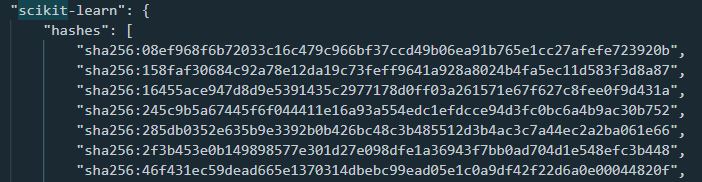

### Q5. Parametrize the script

Let's now make the script configurable via CLI. We'll create two parameters: year and month.

Run the script for March 2021.

What's the mean predicted duration?

- 11.29
- 16.29
- 21.29
- 26.29

Hint: just add a print statement to your script.

In [30]:
!python starter.py "2021" "03"

16.299


### Answer: 16.29

### Q6. Docker contaner

Finally, we'll package the script in the docker container. For that, you'll need to use a base image that we prepared.

This is how it looks like:
```
FROM python:3.9.7-slim

WORKDIR /app
COPY [ "model2.bin", "model.bin" ]
```

We pushed it to `agrigorev/zoomcamp-model:mlops-3.9.7-slim`, which you should use as your base image.

That is, this is how your Dockerfile should start:
```
FROM agrigorev/zoomcamp-model:mlops-3.9.7-slim

# do stuff here
```
This image already has a pickle file with a dictionary vectorizer and a model. You will need to use them.

Important: don't copy the model to the docker image. You will need to use the pickle file already in the image.

Now run the script with docker. What's the mean predicted duration for April 2021?

- 9.96
- 16.55
- 25.96
- 36.55


### Answer: 16.551

In [31]:
!python test_docker.py "2021" "04"

{'average prediction': 16.551}
